# WeRateDogs Tweets

The goal of this project is to wrangle tweets from **WeRateDogs** Twitter's account and create interesting and trustworthy analysis & visualizations by using Python and document whole process.

## Table of Contents
- [Data Gathering](#gather)
- [Assessing Data](#asses)
- [Data Cleaning](#clean)
- [Storing Data](#store)
- [Analyzing and Visualizing Data](#analyze)

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tweepy
import json
import re
from bs4 import BeautifulSoup
import missingno as msno

%matplotlib inline

<a id='gather'></a>
## Data Gathering
Data Gathering is the first step in data wrangling process. For this project I gather data from three different sources.
1. First dataset is about tweets of the WeRateDogs twitter account from 2015 to 2017 available on kaggle.
2. Second dataset is about the result of the machine learning algorithm performed on the images from the WeRateDogs account available on kaggle.
3. Third dataset contains retweet and favorite count which I web scrapped off Twitter using its Tweepy API. 

**Gathering WeRateDogs Twitter Archive**

In [2]:
# reading 'twitter-archive-enhanced' dataset
twitter_archived = pd.read_csv('twitter-archive-enhanced.csv')

**Gathering Tweet Image Predictions**

In [3]:
# url for tweet image prediction file
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

# name of file
filename = 'image-predictions.tsv'

response = requests.get(url)

# writing response content to file
with open(filename, mode='wb') as file:
    file.write(response.content)

In [4]:
# reading 'image-predictions.tsv' dataset
img_prediction = pd.read_csv('image-predictions.tsv', sep='\t')

**Gathering Data From Twitter API**

In [5]:
# importing tweepy library
import tweepy

# secret and public keys
consumer_key = '###################'
consumer_secret = '###################'
access_token = '###################'
access_secret = '###################'


try:
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

except tweepy.TweepError as e:
    print(e.message)
    

api = tweepy.API(auth,
                 parser=tweepy.parsers.JSONParser(),
                 wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)

In [6]:
tweets = twitter_archived['tweet_id']

tweets_data = []
tweets_error = []

for id in tweets:
    try:
        page = api.get_status(id, tweet_mode='extended')
        
        tweets_data.append({'tweet_id':page['id'],
                            'created_at':page['created_at'],
                            'favorite_count':page['favorite_count'],
                            'retweet_count':page['retweet_count']})
    
    except tweepy.TweepError as e:
        print('{} : {}'.format(id, e)) 
        tweets_error.append(id)
            
print('Number of tweet ids whose data collected correctly:{}'.format(len(tweets_data)))
print('Number of error:{}'.format(len(tweets_error)))

888202515573088257 : [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 : [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 : [{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745 : [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 : [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 : [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 : [{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130 : [{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560 : [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 : [{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984 : [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 : [{'code': 144, 'message': 'No status found with that ID.'}]
837366284874571778 : [{'code

Rate limit reached. Sleeping for: 13


754011816964026368 : [{'code': 144, 'message': 'No status found with that ID.'}]
680055455951884288 : [{'code': 144, 'message': 'No status found with that ID.'}]


Rate limit reached. Sleeping for: 96


Number of tweet ids whose data collected correctly:2331
Number of error:25


In [110]:
# writing tweets data to json file
json.dump(tweets_data,open('tweet_json.txt', 'w', encoding="utf8"), ensure_ascii=False, indent=4)

print('Done!!!')

Done!!!


In [111]:
# reading json file into pandas dataframe
with open('tweet_json.txt','r') as file:
    data = json.load(file)

tweet_df = pd.DataFrame(data)

<a id='asses'></a>
## Assessing Data

Assessing data is the second step in the data wrangling process. In this step I assess the data quality and tidiness issues by visually and programmatically. 

**Assessing twitter_archived dataset**

In [9]:
# looking twitter_archived table
twitter_archived.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


|Column Names|Description|
|:---|:---|
|tweet_id|Unique identifier for Tweets.|
|in_reply_to_status_id|Representes Tweet is a replied. Contains the string representation of the original Tweet’s ID.|
|in_reply_to_user_id|Representes Tweet is a replied. Contains the integer representation of the original Tweet’s author ID.|
|timestamp|Date and time when the tweet get created.|
|source|Utility used to post the Tweets.|
|text|Shows status update.|
|retweeted_status_id|Unique id assigned for the retweeted messages.|
|retweeted_status_user_id|Id of the user who retweeted the message.|
|retweeted_status_timestamp|Time when the original tweet was retweeted.|
|expanded_urls|Links to the media display page.|
|rating_numerator|Numerator part of rating.|
|rating_denominator|Denominator part of rating.|
|name|The name of the user. Not necessarily a person’s name.|
|doggo|Dog Stage|
|floofer|Dog Stage|
|pupper|Dog Stage|
|puppo|Dog Stage|


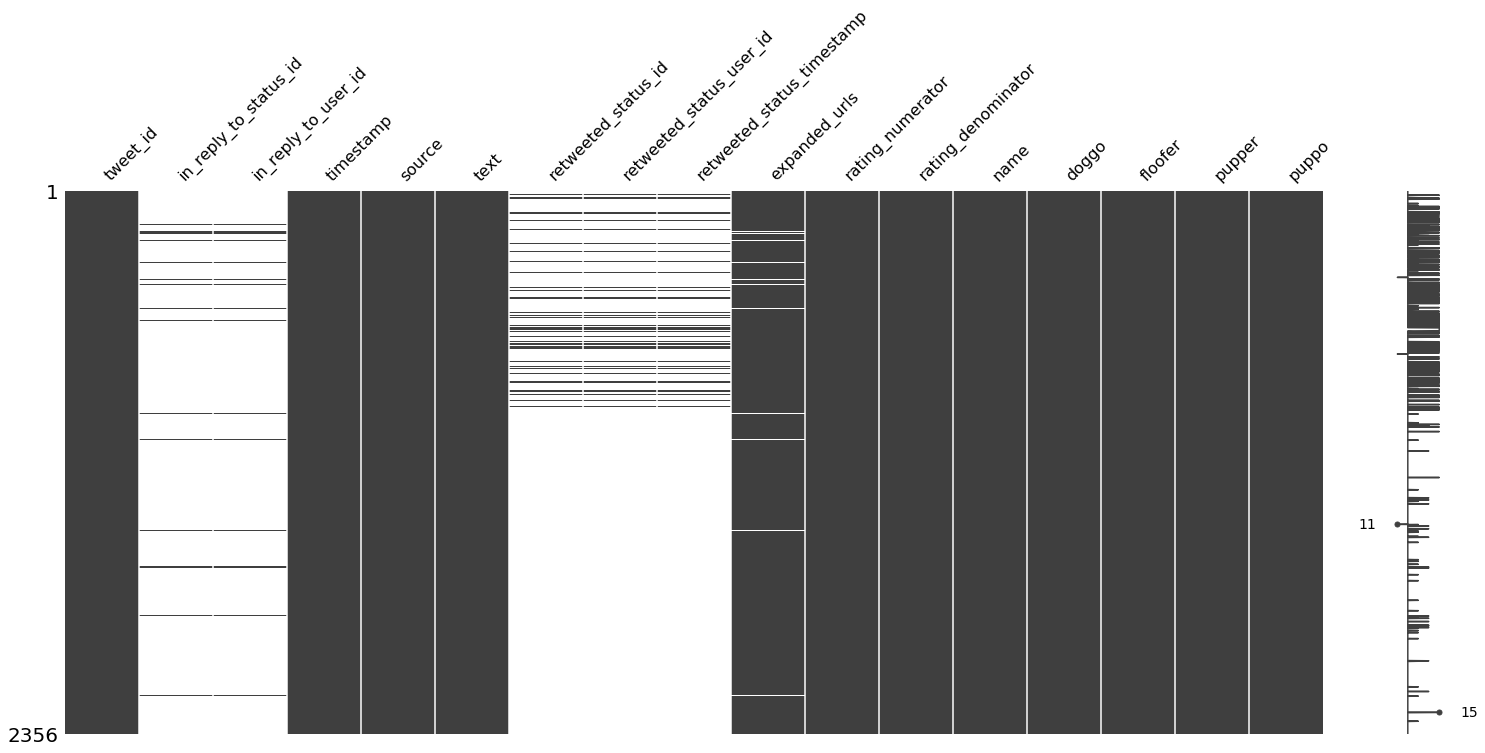

In [10]:
msno.matrix(twitter_archived);

In [11]:
# viewing concise information about twitter_archived table
twitter_archived.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
twitter_archived.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [13]:
twitter_archived['expanded_urls'].duplicated().sum()

137

In [14]:
twitter_archived['rating_numerator'].describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [15]:
twitter_archived['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [16]:
twitter_archived['rating_denominator'].describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [17]:
twitter_archived['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [18]:
twitter_archived['name'].value_counts()

None            745
a                55
Charlie          12
Oliver           11
Cooper           11
Lucy             11
Lola             10
Penny            10
Tucker           10
Bo                9
Winston           9
the               8
Sadie             8
Toby              7
an                7
Daisy             7
Bailey            7
Buddy             7
Koda              6
Jack              6
Oscar             6
Bella             6
Milo              6
Stanley           6
Dave              6
Jax               6
Scout             6
Rusty             6
Leo               6
Sunny             5
               ... 
Remus             1
Ziva              1
Angel             1
Goose             1
Chase             1
Dewey             1
old               1
Bobble            1
Stu               1
William           1
Jiminus           1
Siba              1
Bloo              1
Napolean          1
Milky             1
unacceptable      1
Mairi             1
Cannon            1
Mark              1


**Assessing img_prediction dataset**

In [19]:
img_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


|**Column Names**|**Description**|
|:---|:---|
|tweet_id|Unique identifier for Tweets.|
|jpg_url|Url of picture.|
|img_num|Number of images.|
|p1|p1 is the algorithm's prediction for the image in the tweet.|
|p1_conf|How confident the algorithm is in its p1 prediction.|
|p1_dog|Whether or not the p1 prediction is a breed of dog. Contains boolean value.|
|p2|p2 is the algorithm's second most likely prediction.|
|p2_conf|How confident the algorithm is in its p2 prediction.|
|p2_dog|Whether or not the p2 prediction is a breed of dog.|
|p3|p3 is the algorithm's second most likely prediction.|
|p3_conf|How confident the algorithm is in its p3 prediction.|
|p3_dog|Whether or not the p3 prediction is a breed of dog.|

In [20]:
img_prediction.shape

(2075, 12)

In [21]:
img_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [22]:
img_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [23]:
img_prediction['jpg_url'].duplicated().sum()

66

In [24]:
img_prediction['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
Siberian_husky                20
Staffordshire_bullterrier     20
German_shepherd               20
Cardigan                      19
web_site                      19
Shetland_sheepdog             18
Maltese_dog                   18
teddy                         18
Eskimo_dog                    18
beagle                        18
Shih-Tzu                      17
Rottweiler                    17
Lakeland_terrier              17
Italian_greyhound             16
kuvasz                        16
          

In [25]:
len(img_prediction[(img_prediction['p1_dog'] == False) & (img_prediction['p2_dog'] == False) & (img_prediction['p3_dog'] == False)])

324

**Assessing tweet_df dataset**

In [26]:
tweet_df.head()

,created_at,favorite_count,retweet_count,tweet_id
0,Tue Aug 01 16:23:56 +0000 2017,36134,7695,892420643555336193
1,Tue Aug 01 00:17:27 +0000 2017,31153,5690,892177421306343426
2,Mon Jul 31 00:18:03 +0000 2017,23471,3774,891815181378084864
3,Sun Jul 30 15:58:51 +0000 2017,39399,7851,891689557279858688
4,Sat Jul 29 16:00:24 +0000 2017,37619,8466,891327558926688256


|**Columns Name**|**Description**|
|:---|:---|
|created_at|Date and time of tweet.|
|favourite_count|No of times is favourite.|
|retweet_count|No of times tweet is retweet|
|tweet_id|Unique identifier for Tweets.|

In [27]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
created_at        2331 non-null object
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
tweet_id          2331 non-null int64
dtypes: int64(3), object(1)
memory usage: 72.9+ KB


In [28]:
tweet_df['favorite_count'].describe()

count      2331.000000
mean       7542.213642
std       11704.594812
min           0.000000
25%        1315.500000
50%        3281.000000
75%        9235.000000
max      155750.000000
Name: favorite_count, dtype: float64

In [29]:
tweet_df.duplicated().sum()

0

### Documenting Issues

### Quality Issues

1. Remove all the tweets that have retweets.
2. Remove all the tweets that have reply.
3. Remove duplicates.
4. Datatype of tweet_id is int64 not str.
5. Datatype of timestamp and created_at is object not datetime.
6. Removing tweets that does not have images.
7. Correcting invlid dog names.
8. Extracting tweet source from source column.
9. Fixing rating denominator.
10. Making all rows equal.


### Tidiness Issues

1. Dog stages have values as columns, instead of one column with their values.
2. Prediction algorithm coulumns should melted into one column.
2. All three datasets should connected to one dataset.

<a id='clean'></a>
## Data Cleaning
Data cleaning is the final step of data wrangling process.

In [30]:
# making copying of all dataset
twitter_archived_clean = twitter_archived.copy()
img_prediction_clean = img_prediction.copy()
tweet_df_clean = tweet_df.copy()

### Cleaning For Tidiness

**1. Dog stages have values as columns, instead of one column with their values.**

**Define**
* Create new column and assign dog_stage.
* Drop doggo, floofer, pupper, puppo columns.

**Code**

In [31]:
# dog stages to iterate
stage_cols = ['doggo', 'floofer', 'pupper', 'puppo']

# make new column with all none value
twitter_archived_clean['dog_stage'] = 'None'

# loop through each columns, if all are none then move on,
# if not set column name as stage for dog_stage
for i in twitter_archived_clean.index:
    for column in stage_cols:
        if twitter_archived_clean.at[i, column] == 'None':
            continue
        else:
            twitter_archived_clean.at[i, 'dog_stage'] = column

In [32]:
# dropping columns
twitter_archived_clean = twitter_archived_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1)

**Test**

In [33]:
twitter_archived_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stage                     2356 non-null object
dtypes: float64(4), int64(3), object(7)
memory usage: 257.8+ KB


**2. Combining prediction columns.**

**Define**
* Write a function that melt all prediction algorithm columns to on column with confidence column.
* Apply that function.
* Drop columns.

**Code**

In [34]:
breed_prediction = []
breed_confidence = []

# prediction function:
# search the first true algorithm and append it to breed_prediction list with its level of breed_confidence
# if flase prediction_algorthm will have a value of NaN
def prediction(df):
    if df['p1_dog'] == True:
        breed_prediction.append(df['p1'])
        breed_confidence.append(df['p1_conf'])
    elif df['p2_dog'] == True:
        breed_prediction.append(df['p2'])
        breed_confidence.append(df['p2_conf'])
    elif df['p3_dog'] == True:
        breed_prediction.append(df['p3'])
        breed_confidence.append(df['p3_conf'])
    else:
        breed_prediction.append('NaN')
        breed_confidence.append(0)

img_prediction_clean.apply(prediction, axis=1)

img_prediction_clean['breed_prediction'] = breed_prediction
img_prediction_clean['breed_confidence'] = breed_confidence

In [35]:
img_prediction_clean = img_prediction_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)

**Test**

In [36]:
img_prediction_clean.columns.tolist()

['tweet_id', 'jpg_url', 'breed_prediction', 'breed_confidence']

In [37]:
img_prediction_clean.head()

,tweet_id,jpg_url,breed_prediction,breed_confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311


**3. Merging three datasets into one dataset.**

**Define**
* Merge `twitter_archived_clean` and `img_prediction_clean` to one dataset called `twitter_master`
* Merge `twitter_master` and `tweet_df_clean`.

**Code**

In [38]:
# merging 'twitter_archived_clean' and 'img_prediction'
twitter_master = pd.merge(twitter_archived_clean, img_prediction_clean, how = 'left', on = ['tweet_id'] )

In [39]:
# merging 'twitter_master' and 'tweet_df_clean'
twitter_master = pd.merge(twitter_master, tweet_df_clean, how = 'left', on = ['tweet_id'])

**Test**

In [40]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 20 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
dog_stage                     2356 non-null object
jpg_url                       2075 non-null object
breed_prediction              2075 non-null object
breed_confidence              2075 non-null float64
created_at                    2

In [41]:
twitter_master.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,breed_prediction,breed_confidence,created_at,favorite_count,retweet_count
1335,705239209544720384,NaN,NaN,2016-03-03 03:51:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jimothy. He lost his body during the t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/705239209...,11,10,Jimothy,None,https://pbs.twimg.com/media/CcmDUjFW8AAqAjc.jpg,Chihuahua,0.157950,Thu Mar 03 03:51:44 +0000 2016,2986.0,745.0
1604,685906723014619143,NaN,NaN,2016-01-09 19:31:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Olive. He's stuck in a sleeve. 9/10 da...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685906723...,9,10,Olive,None,https://pbs.twimg.com/media/CYTUhn7WkAEXocW.jpg,Yorkshire_terrier,0.414963,Sat Jan 09 19:31:20 +0000 2016,7458.0,2867.0
2338,666104133288665088,NaN,NaN,2015-11-16 04:02:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Not familiar with this breed. No tail (weird)....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666104133...,1,10,None,None,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,NaN,0.000000,Mon Nov 16 04:02:55 +0000 2015,13613.0,5977.0
1228,713900603437621249,NaN,NaN,2016-03-27 01:29:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg,golden_retriever,0.371816,Sun Mar 27 01:29:02 +0000 2016,2804.0,737.0
1768,678389028614488064,NaN,NaN,2015-12-20 01:38:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She just learned that her final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678389028...,11,10,Bella,pupper,https://pbs.twimg.com/media/CWofOHUWUAACGVa.jpg,miniature_pinscher,0.516284,Sun Dec 20 01:38:42 +0000 2015,1850.0,418.0


### Cleaning For Quality

**1. Removing all the tweets that are retweeted.**

**Define** <br>
* Filter all the rows that does not contain retweets.
* Drop `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` columns.

**Code**

In [42]:
# filtering rows that does not have values in retweeted_status_id column
twitter_master = twitter_master[twitter_master['retweeted_status_id'].isnull()]

In [43]:
# dropping columns that contains retweet values
twitter_master = twitter_master.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1)

**Test**

In [44]:
# testing 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp' are dropped
twitter_master.columns.tolist()

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage',
 'jpg_url',
 'breed_prediction',
 'breed_confidence',
 'created_at',
 'favorite_count',
 'retweet_count']

**2. Removing all the rows that have reply.**

**Define** <br>
* Filter all rows that does not have value in `in_reply_to_status_id` column.
* Drop `in_reply_to_status_id` and `in_reply_to_user_id` columns as they are not right tweets with image ratings.

**Code**

In [45]:
# filtering all rows that don't have values in in_reply_to_status_id column
twitter_master = twitter_master[twitter_master['in_reply_to_status_id'].isnull()]

In [46]:
# dropping reply columns
twitter_master = twitter_master.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis = 1)

**Test**

In [47]:
twitter_master.columns.tolist()

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage',
 'jpg_url',
 'breed_prediction',
 'breed_confidence',
 'created_at',
 'favorite_count',
 'retweet_count']

**3. Remove all the rows where expanded_url are duplicated.**

**Define**
* drop duplicate expanded_url.

**Code**

In [48]:
twitter_master = twitter_master.drop_duplicates(subset = 'expanded_urls', keep='first')

**Test**

In [49]:
twitter_master['expanded_urls'].duplicated().sum()

0

In [50]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              2094 non-null int64
timestamp             2094 non-null object
source                2094 non-null object
text                  2094 non-null object
expanded_urls         2093 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
dog_stage             2094 non-null object
jpg_url               1971 non-null object
breed_prediction      1971 non-null object
breed_confidence      1971 non-null float64
created_at            2087 non-null object
favorite_count        2087 non-null float64
retweet_count         2087 non-null float64
dtypes: float64(3), int64(3), object(9)
memory usage: 261.8+ KB


**4. Datatype of tweet_id is int64 not str.**<br>

**Define**
* Convert datatype of `tweet_id` column from int64 to string by using astype().

**Code**

In [51]:
# converting tweet_id into string type
twitter_master['tweet_id'] = twitter_master['tweet_id'].astype('str')

**Test**

In [52]:
twitter_master.dtypes

tweet_id               object
timestamp              object
source                 object
text                   object
expanded_urls          object
rating_numerator        int64
rating_denominator      int64
name                   object
dog_stage              object
jpg_url                object
breed_prediction       object
breed_confidence      float64
created_at             object
favorite_count        float64
retweet_count         float64
dtype: object

**5. Datatype of timestamp and created_at is object not datetime.**

**Define**

* Convert datatype of `timestamp` column from object to datatime.
* Convert datatype of `created_at` column from object to datatime.

In [53]:
# converting timestamp into DateTime
twitter_master['timestamp'] = pd.to_datetime(twitter_master['timestamp'])

In [54]:
# converting created_at into DateTime
twitter_master['created_at'] = pd.to_datetime(twitter_master['created_at'])

**Test**

In [55]:
twitter_master.dtypes

tweet_id                           object
timestamp             datetime64[ns, UTC]
source                             object
text                               object
expanded_urls                      object
rating_numerator                    int64
rating_denominator                  int64
name                               object
dog_stage                          object
jpg_url                            object
breed_prediction                   object
breed_confidence                  float64
created_at            datetime64[ns, UTC]
favorite_count                    float64
retweet_count                     float64
dtype: object

**5. Changing datatype of source and dog_stage column to category**

**Define**
* change datatype to category by using astype.

**Code**

In [56]:
twitter_master['source'] = twitter_master['source'].astype('category')
twitter_master['dog_stage'] = twitter_master['dog_stage'].astype('category')

**Test**

In [57]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              2094 non-null object
timestamp             2094 non-null datetime64[ns, UTC]
source                2094 non-null category
text                  2094 non-null object
expanded_urls         2093 non-null object
rating_numerator      2094 non-null int64
rating_denominator    2094 non-null int64
name                  2094 non-null object
dog_stage             2094 non-null category
jpg_url               1971 non-null object
breed_prediction      1971 non-null object
breed_confidence      1971 non-null float64
created_at            2087 non-null datetime64[ns, UTC]
favorite_count        2087 non-null float64
retweet_count         2087 non-null float64
dtypes: category(2), datetime64[ns, UTC](2), float64(3), int64(2), object(6)
memory usage: 233.5+ KB


**6. Removing tweets that does not have images.**

**Define**
* Filter all tweets that have images.

**Code**

In [58]:
# removing tweets without images
twitter_master = twitter_master[pd.notnull(twitter_master['jpg_url'])]

**Test**

In [59]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              1971 non-null object
timestamp             1971 non-null datetime64[ns, UTC]
source                1971 non-null category
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
dog_stage             1971 non-null category
jpg_url               1971 non-null object
breed_prediction      1971 non-null object
breed_confidence      1971 non-null float64
created_at            1964 non-null datetime64[ns, UTC]
favorite_count        1964 non-null float64
retweet_count         1964 non-null float64
dtypes: category(2), datetime64[ns, UTC](2), float64(3), int64(2), object(6)
memory usage: 219.8+ KB


**7. Correcting dog names.**

**Define**



**Code**

In [60]:
pd.set_option('display.max_colwidth', -1)

vals = twitter_master[~twitter_master['name'].str[0].str.isupper()]['name'].value_counts()
vals.keys()
pd.reset_option('display.max_colwidth')

In [61]:
for val in vals.keys():
    twitter_master['name'] = twitter_master['name'].replace(val,'None')

**Test**

In [62]:
twitter_master['name'].value_counts()

None         622
Charlie       11
Oliver        10
Lucy          10
Cooper        10
Penny          9
Tucker         9
Winston        8
Sadie          8
Toby           7
Daisy          7
Lola           7
Bella          6
Stanley        6
Bo             6
Koda           6
Jax            6
Buddy          5
Rusty          5
Chester        5
Dave           5
Oscar          5
Bailey         5
Scout          5
Louis          5
Milo           5
Leo            5
Dexter         4
Finn           4
Derek          4
            ... 
Boots          1
Tedrick        1
Jareld         1
Remus          1
Ziva           1
Yoda           1
Reagan         1
Blu            1
Bloo           1
Sierra         1
Ricky          1
Asher          1
Opie           1
Smiley         1
Bobble         1
William        1
Jiminus        1
Siba           1
Napolean       1
Grizzwald      1
Milky          1
Mairi          1
Cannon         1
Stu            1
Mark           1
Maddie         1
Timmy          1
Reptar        

**8. Extracting tweet source from source column.**

**Define**
* Use BeautifulSoup to extract source source.

**Code**

In [63]:
# function for extracting tag content
def tweet_source(file):
    soup = BeautifulSoup(file, 'lxml')
    return soup.a.string

In [64]:
# change each cell to tag content
twitter_master['source'] = twitter_master.apply(lambda x: tweet_source(x['source']), axis = 1)

In [65]:
# dictionary of source tag
source_tag = {'Twitter for iPhone': 'iphone',
              'Vine - Make a Scene': 'vine',
              'Twitter Web Client': 'web',
              'TweetDeck': 'tweetdeck'
             }

In [66]:
# apply function
twitter_master['source'] = twitter_master['source'].replace(source_tag)

**Test**

In [67]:
twitter_master.sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,breed_prediction,breed_confidence,created_at,favorite_count,retweet_count
1389,700167517596164096,2016-02-18 03:58:39+00:00,iphone,This is Dotsy. She's stuck as hell. 10/10 http...,https://twitter.com/dog_rates/status/700167517...,10,10,Dotsy,None,https://pbs.twimg.com/media/Cbd-o8hWwAE4OFm.jpg,beagle,0.162585,2016-02-18 03:58:39+00:00,2616.0,730.0
1838,675898130735476737,2015-12-13 04:40:46+00:00,iphone,I'm sure you've all seen this pupper. Not prep...,https://twitter.com/dog_rates/status/675898130...,10,10,None,pupper,https://pbs.twimg.com/media/CWFFt3_XIAArIYK.jpg,Labrador_retriever,0.407430,2015-12-13 04:40:46+00:00,1576.0,558.0
330,833124694597443584,2017-02-19 01:23:00+00:00,iphone,This is Gidget. She's a spy pupper. Stealthy a...,https://twitter.com/dog_rates/status/833124694...,12,10,Gidget,pupper,https://pbs.twimg.com/media/C4_ad1IUoAEspsk.jpg,Cardigan,0.710523,2017-02-19 01:23:00+00:00,20243.0,4857.0
351,831322785565769729,2017-02-14 02:02:51+00:00,iphone,This is Pete. He has no eyes. Needs a guide do...,https://twitter.com/dog_rates/status/831322785...,12,10,Pete,doggo,https://pbs.twimg.com/media/C4lzqQ4UEAApzU0.jpg,Old_English_sheepdog,0.999715,2017-02-14 02:02:51+00:00,9312.0,1563.0
651,792773781206999040,2016-10-30 17:02:53+00:00,iphone,This is Monster. Not an actual monster tho. He...,https://twitter.com/dog_rates/status/792773781...,12,10,Monster,None,https://pbs.twimg.com/media/CwB_i-zXEAEiP29.jpg,Yorkshire_terrier,0.912804,2016-10-30 17:02:53+00:00,7482.0,1714.0
2246,667878741721415682,2015-11-21 01:34:35+00:00,iphone,This is Tedrick. He lives on the edge. Needs s...,https://twitter.com/dog_rates/status/667878741...,2,10,Tedrick,None,https://pbs.twimg.com/media/CUTILFiWcAE8Rle.jpg,miniature_pinscher,0.106003,2015-11-21 01:34:35+00:00,378.0,113.0
809,771500966810099713,2016-09-02 00:12:18+00:00,iphone,This is Dakota. He's just saying hi. That's al...,https://twitter.com/dog_rates/status/771500966...,12,10,Dakota,None,https://pbs.twimg.com/media/CrTsCPHWYAANdzC.jpg,Labrador_retriever,0.833952,2016-09-02 00:12:18+00:00,8333.0,2634.0
957,751538714308972544,2016-07-08 22:09:27+00:00,iphone,This is Max. She has one ear that's always sli...,https://twitter.com/dog_rates/status/751538714...,10,10,Max,None,https://pbs.twimg.com/media/Cm4AeG8XEAAulD2.jpg,Labrador_retriever,0.516257,2016-07-08 22:09:27+00:00,5040.0,1266.0
1197,717009362452090881,2016-04-04 15:22:08+00:00,iphone,This is Smokey. He's having some sort of exist...,https://twitter.com/dog_rates/status/717009362...,10,10,Smokey,pupper,https://pbs.twimg.com/media/CfNUNetW8AAekHx.jpg,Siberian_husky,0.506154,2016-04-04 15:22:08+00:00,3220.0,954.0
2092,670782429121134593,2015-11-29 01:52:48+00:00,iphone,This dude slaps your girl's ass what do you do...,https://twitter.com/dog_rates/status/670782429...,5,10,None,None,https://pbs.twimg.com/media/CU8ZDu9WwAADg3N.jpg,Chihuahua,0.952963,2015-11-29 01:52:48+00:00,1494.0,733.0


**9. Fixing rating denominator.**

**Code**

In [68]:
# fixing rating denominator
print("Tweets contains '/10' in the text : {}".format(twitter_master[~twitter_master['text'].str.contains('/10')]['tweet_id'].count()))
print("Tweets not contains 10 in denominator : {}".format(twitter_master[twitter_master['rating_denominator'] != 10]['tweet_id'].count()))

Tweets contains '/10' in the text : 12
Tweets not contains 10 in denominator : 17


In [69]:
twitter_master = twitter_master[twitter_master['text'].str.contains('/10')]

In [70]:
print("Tweets not contain 10 in denominator : {}".format(twitter_master[twitter_master['rating_denominator'] != 10]['tweet_id'].count()))

Tweets not contain 10 in denominator : 5


In [71]:
twitter_master[twitter_master['rating_denominator'] != 10].text

1068    After so many requests, this is Bretagne. She ...
1165    Happy 4/20 from the squad! 13/10 for all https...
1202    This is Bluebert. He just saw that both #Final...
1662    This is Darrel. He just robbed a 7/11 and is i...
2335    This is an Albanian 3 1/2 legged  Episcopalian...
Name: text, dtype: object

In [72]:
not_10 = twitter_master[twitter_master['rating_denominator'] != 10].index

for i in not_10:
    twitter_master.at[i, 'rating_denominator'] = 10

In [73]:
# fixing rating numerator
twitter_master['rating_numerator'].value_counts()

12      446
10      417
11      392
13      253
9       150
8        95
7        52
14       33
5        33
6        32
3        19
4        16
2         9
1         5
1776      1
420       1
26        1
27        1
50        1
75        1
0         1
Name: rating_numerator, dtype: int64

In [74]:
fix_manually = set()
fix_by_code = set()

for i in twitter_master.index:
    idx = int(twitter_master.loc[i].text.find('/10'))
    
    try:
        num = int(twitter_master.loc[i].text[idx-2:idx].strip())
    
    except:
        fix_manually.add(i)
        continue
    
    if num != twitter_master.loc[i].rating_numerator:
        fix_by_code.add(i)

print('Ratings that fix by manually: {}'.format(len(fix_manually)))
print('Ratings that fix by code: {}'.format(len(fix_by_code)))

Ratings that fix by manually: 7
Ratings that fix by code: 7


In [75]:
for i in fix_by_code:
    print('{} - {}'.format(i, twitter_master.loc[i]['text']))

1068 - After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
1165 - Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
1202 - This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
979 - This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
2074 - After so many requests... here you go.

Good dogg. 420/10 https://t.co/yfAAo1gdeY
1662 - This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
2335 - This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv


In [76]:
for i in fix_by_code:
    idx = int(twitter_master.loc[i].text.find('/10'))
    num = int(twitter_master.loc[i].text[idx-2:idx].strip())
    twitter_master.loc[i,'rating_numerator'] = num

In [77]:
for i in fix_manually:
    print('{} - {}'.format(i, twitter_master.loc[i]['text']))

1025 - This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt
2246 - This is Tedrick. He lives on the edge. Needs someone to hit the gas tho. Other than that he's a baller. 10&amp;2/10 https://t.co/LvP1TTYSCN
1610 - For the last time, WE. DO. NOT. RATE. BULBASAUR. We only rate dogs. Please only send dogs. Thank you ...9/10 https://t.co/GboDG8WhJG
45 - This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
1653 - "Hello forest pupper I am house pupper welcome to my abode" (8/10 for both) https://t.co/qFD8217fUT
1435 - Please stop sending in saber-toothed tigers. This is getting ridiculous. We only rate dogs.
...8/10 https://t.co/iAeQNueou8
1372 - I know it's tempting, but please stop sending in pics of Donald Trump. Thank you ...9/10 https://t.co/y35Y1TJERY


In [78]:
twitter_master.loc[1025,'rating_numerator'] = 9
twitter_master.loc[2246,'rating_numerator'] = 12
twitter_master.loc[1610,'rating_numerator'] = 9
twitter_master.loc[45,'rating_numerator'] = 13.5
twitter_master.loc[1653,'rating_numerator'] = 8
twitter_master.loc[1435,'rating_numerator'] = 8
twitter_master.loc[1372,'rating_numerator'] = 9

In [79]:
twitter_master['rating_numerator'].value_counts()

12.0    447
10.0    418
11.0    393
13.0    254
9.0     150
8.0      95
7.0      51
14.0     34
5.0      32
6.0      32
3.0      19
4.0      15
2.0       8
1.0       4
27.0      1
20.0      1
0.0       1
76.0      1
26.0      1
13.5      1
75.0      1
Name: rating_numerator, dtype: int64

In [80]:
twitter_master['rating_denominator'].value_counts()

10    1959
Name: rating_denominator, dtype: int64

In [81]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1959 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              1959 non-null object
timestamp             1959 non-null datetime64[ns, UTC]
source                1959 non-null object
text                  1959 non-null object
expanded_urls         1959 non-null object
rating_numerator      1959 non-null float64
rating_denominator    1959 non-null int64
name                  1959 non-null object
dog_stage             1959 non-null category
jpg_url               1959 non-null object
breed_prediction      1959 non-null object
breed_confidence      1959 non-null float64
created_at            1952 non-null datetime64[ns, UTC]
favorite_count        1952 non-null float64
retweet_count         1952 non-null float64
dtypes: category(1), datetime64[ns, UTC](2), float64(4), int64(1), object(7)
memory usage: 311.7+ KB


**10. Making all rows equal.**

**Define**
* Filter all the rows that are not null.

**Code**

In [82]:
twitter_master = twitter_master[twitter_master['created_at'].notnull()]

**Test**

In [83]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id              1952 non-null object
timestamp             1952 non-null datetime64[ns, UTC]
source                1952 non-null object
text                  1952 non-null object
expanded_urls         1952 non-null object
rating_numerator      1952 non-null float64
rating_denominator    1952 non-null int64
name                  1952 non-null object
dog_stage             1952 non-null category
jpg_url               1952 non-null object
breed_prediction      1952 non-null object
breed_confidence      1952 non-null float64
created_at            1952 non-null datetime64[ns, UTC]
favorite_count        1952 non-null float64
retweet_count         1952 non-null float64
dtypes: category(1), datetime64[ns, UTC](2), float64(4), int64(1), object(7)
memory usage: 230.9+ KB


<a id='store'></a>
## Storing Data

In [84]:
twitter_master.to_csv('twitter_archive_master.csv', index_label=False, encoding = 'utf-8')

In [85]:
pd.read_csv('twitter_archive_master.csv')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,breed_prediction,breed_confidence,created_at,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56+00:00,iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,NaN,0.000000,2017-08-01 16:23:56+00:00,36134.0,7695.0
1,892177421306343426,2017-08-01 00:17:27+00:00,iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,2017-08-01 00:17:27+00:00,31153.0,5690.0
2,891815181378084864,2017-07-31 00:18:03+00:00,iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,2017-07-31 00:18:03+00:00,23471.0,3774.0
3,891689557279858688,2017-07-30 15:58:51+00:00,iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Labrador_retriever,0.168086,2017-07-30 15:58:51+00:00,39399.0,7851.0
4,891327558926688256,2017-07-29 16:00:24+00:00,iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,2017-07-29 16:00:24+00:00,37619.0,8466.0
5,891087950875897856,2017-07-29 00:08:17+00:00,iphone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10,None,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,Chesapeake_Bay_retriever,0.425595,2017-07-29 00:08:17+00:00,18958.0,2834.0
6,890971913173991426,2017-07-28 16:27:12+00:00,iphone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10,Jax,None,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,Appenzeller,0.341703,2017-07-28 16:27:12+00:00,11033.0,1846.0
7,890729181411237888,2017-07-28 00:22:40+00:00,iphone,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13.0,10,None,None,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142,2017-07-28 00:22:40+00:00,60832.0,17165.0
8,890609185150312448,2017-07-27 16:25:51+00:00,iphone,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13.0,10,Zoey,None,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,Irish_terrier,0.487574,2017-07-27 16:25:51+00:00,26084.0,3907.0
9,890240255349198849,2017-07-26 15:59:51+00:00,iphone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14.0,10,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,0.511319,2017-07-26 15:59:51+00:00,29824.0,6677.0


<a id='analyze'></a>
## Analyzing and Visualizing Data

### Seeing Relationship Between Variables

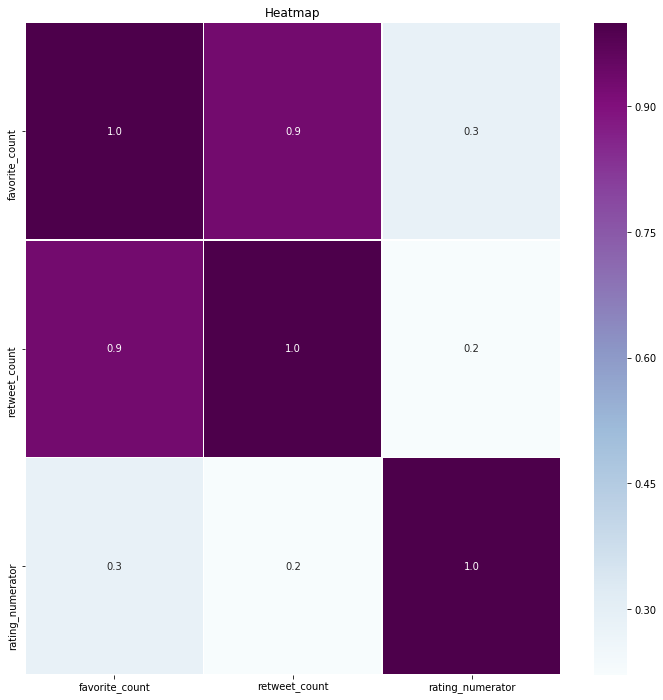

In [86]:
# plotting heatmap
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(twitter_master[['source', 
                            'favorite_count',
                            'retweet_count', 
                            'rating_numerator']].corr(), annot=True, linewidths=0.5, fmt='.1f', ax=ax, cmap="BuPu")
plt.title('Heatmap');

**Observation**
* A strong correlation between favourite_count and retweet_count. This means tweets that have more favorite count also has more retweet count.


### Retweet and Favorite Count Overtime

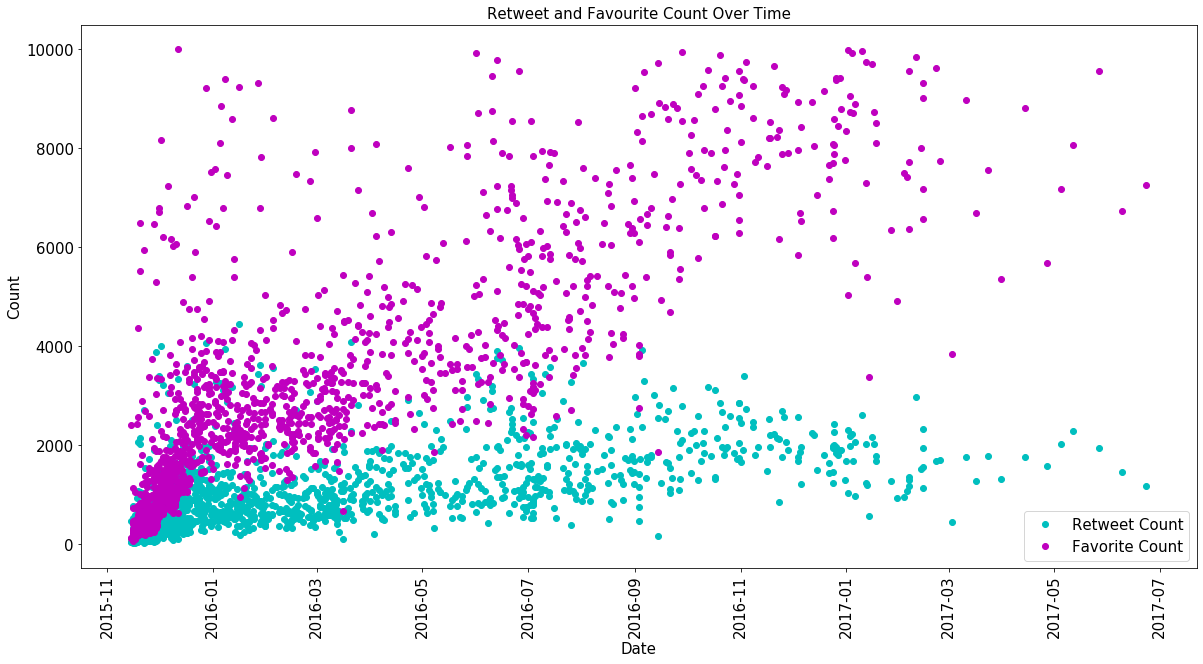

In [109]:
fig, ax = plt.subplots(figsize=(20,10))

date_count = pd.to_datetime(twitter_master[twitter_master.favorite_count < 10000].timestamp).dt.date

plt.plot_date(date_count, twitter_master[twitter_master.favorite_count < 10000].retweet_count, color='c',label='Retweet Count')
plt.plot_date(date_count, twitter_master[twitter_master.favorite_count < 10000].favorite_count, color='m', label='Favorite Count')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Retweet and Favourite Count Over Time', fontsize=15)
plt.legend(fontsize=15)
ax.xaxis.set_tick_params(rotation=90, labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

**Observation**
- Over time retweet decreases and favorite count increases.

###  Most Tweeted Dog Breeds

In [88]:
# top ten breed
twitter_master['breed_prediction'].value_counts().nlargest(10)

NaN                   304
golden_retriever      154
Labrador_retriever    101
Pembroke               94
Chihuahua              90
pug                    62
toy_poodle             49
chow                   47
Samoyed                41
Pomeranian             41
Name: breed_prediction, dtype: int64

In [89]:
# 304 tweets where breed was identify
twitter_master.loc[twitter_master['breed_prediction'] == 'NaN', 'breed_prediction'] = None

In [90]:
# most tweeted breed by ratings
most_tweeted_breed = twitter_master.groupby('breed_prediction').count()['rating_numerator'].sort_values(ascending=False).nlargest(10)
most_tweeted_breed

breed_prediction
golden_retriever      154
Labrador_retriever    101
Pembroke               94
Chihuahua              90
pug                    62
toy_poodle             49
chow                   47
Pomeranian             41
Samoyed                41
malamute               33
Name: rating_numerator, dtype: int64

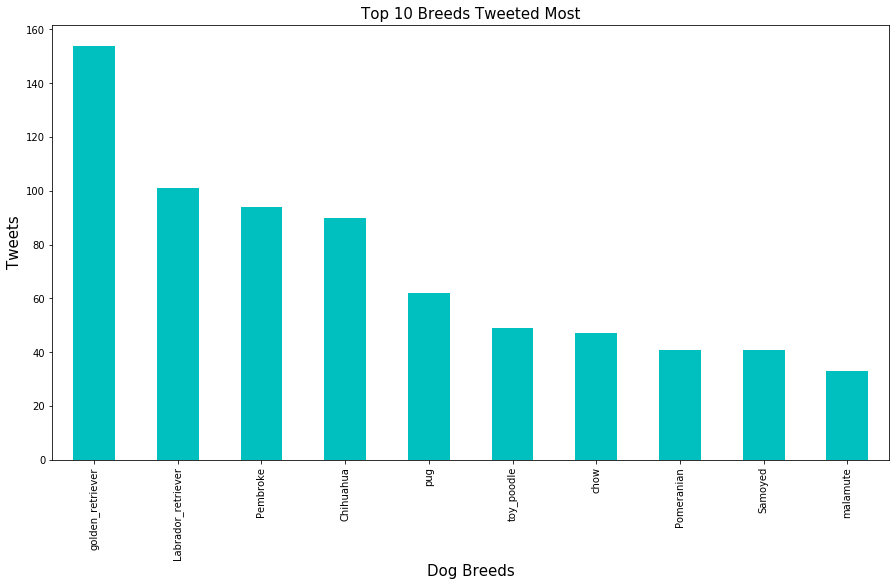

In [91]:
# Bar chart of top 10 breeds
fig = plt.figure(figsize=(15,8))
most_tweeted_breed.plot(kind='bar', color='c')
plt.title("Top 10 Breeds Tweeted Most", fontsize=15)
plt.ylabel("Tweets", fontsize=15)
plt.xlabel("Dog Breeds", fontsize=15);

**Observation**
- Golden retriever tweeted most about 155 tweets.
- Malamute tweeted least about 35 tweets.

### Popular Dog Names

In [92]:
twitter_master.loc[twitter_master['name'] == 'None', 'name'] = None

In [93]:
top_dog_name = twitter_master['name'].value_counts()[:10]

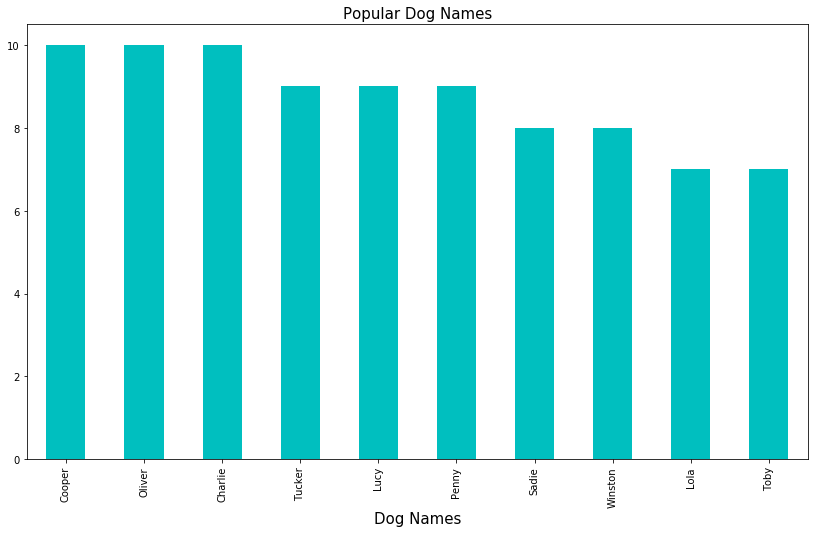

In [94]:
# plotting bar chart of top 10 dog names
top_dog_name.plot(kind='bar', figsize=(14,8), color='c')
plt.title("Popular Dog Names", fontsize=15)
plt.xlabel("Dog Names", fontsize=15);

**Observation**
- Popular dog name is Charlie.

### Distribution of Dog Stage

In [95]:
twitter_master['dog_stage'].value_counts()

None       1650
pupper      209
doggo        62
puppo        23
floofer       8
Name: dog_stage, dtype: int64

In [96]:
stage = twitter_master['dog_stage'].value_counts().head(4).index

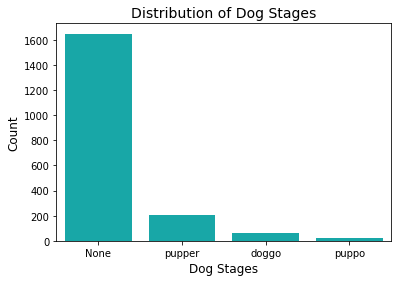

In [97]:
sns.countplot(data = twitter_master, x='dog_stage', order=stage, color='c')
plt.xlabel('Dog Stages', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Dog Stages',fontsize=14);

**Observation**
- Most of the dog have 'pupper' dog stage. This is because small dogs looks cute and loved more.
- Note most of the dog don't have dog stage.

### Distribution of Tweet Source 

In [98]:
twitter_master['source'].value_counts()

iphone       1914
web            28
tweetdeck      10
Name: source, dtype: int64

In [99]:
twitter_master['source'].value_counts().index

Index(['iphone', 'web', 'tweetdeck'], dtype='object')

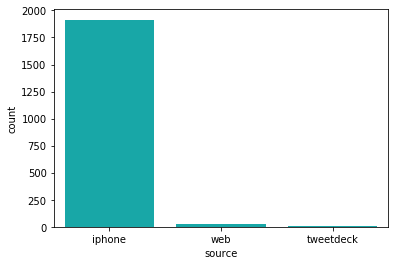

In [100]:
sns.countplot(data=twitter_master, x='source', color='c');

**Observation**
- Most of the tweets were done through iphone.
- Very small amount of tweets done from web app and tweet deck.

### Most Rated Dog Breeds

In [101]:
breed_count = twitter_master['breed_prediction'].value_counts()

# dataframe which includes dog breeds with at least 10 counts
df1 = twitter_master[twitter_master['breed_prediction'].isin(breed_count[breed_count > 9].index)]

In [102]:
# removing outliers
df2 = df1[df1['rating_numerator'] <= 14]

In [103]:
# top 20 most rated dog breed
most_rated_breed = df2.groupby('breed_prediction')['rating_numerator'].mean().sort_values(ascending=False).nlargest(20)

most_rated_breed

breed_prediction
Samoyed                 11.731707
golden_retriever        11.626623
Great_Pyrenees          11.428571
Pembroke                11.425532
Eskimo_dog              11.409091
chow                    11.404255
cocker_spaniel          11.333333
kelpie                  11.307692
Siberian_husky          11.300000
Bernese_mountain_dog    11.272727
Labrador_retriever      11.168317
French_bulldog          11.166667
Cardigan                11.142857
Blenheim_spaniel        11.100000
Pekinese                11.000000
German_shepherd         11.000000
Rottweiler              11.000000
toy_poodle              10.979592
Pomeranian              10.975000
schipperke              10.923077
Name: rating_numerator, dtype: float64

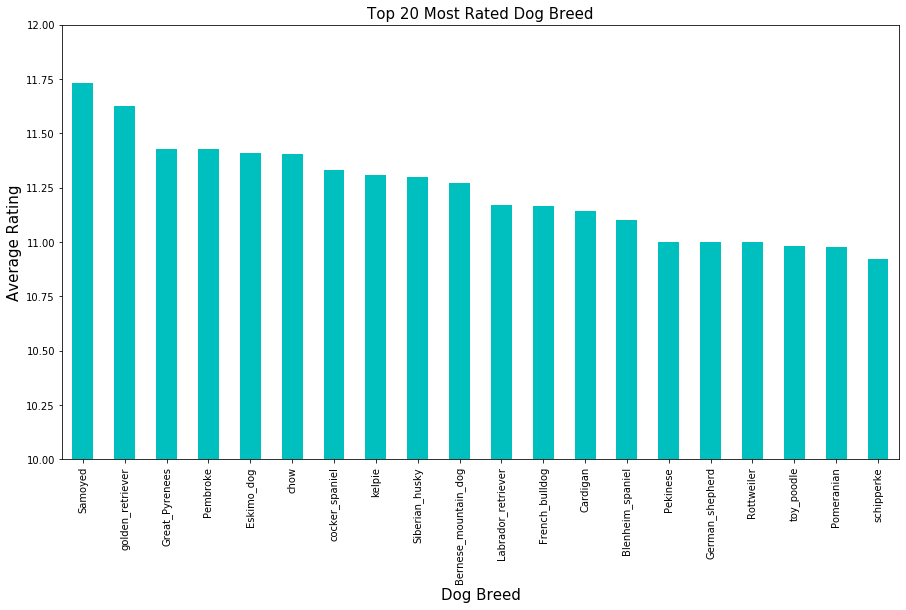

In [104]:
# plotting bar chart of top 20 most rated dog breed 
fig = plt.figure(figsize=(15,8))
most_rated_breed.plot(kind='bar', color='c')
plt.title("Top 20 Most Rated Dog Breed", fontsize=15)
plt.ylabel("Average Rating", fontsize=15)
plt.xlabel("Dog Breed", fontsize=15)
plt.ylim(10,12);

**Observation**
-  Most rated dog breed are Samoyed, Golden_Retriever, Great_Pyrenees and Pembroke.

### Dog Breed With Most Favorite Count

In [105]:
fav_sum = df2.groupby('breed_prediction')['favorite_count'].sum()

In [106]:
fav_count = df2.groupby('breed_prediction')['favorite_count'].count()

In [107]:
# favorite count per tweet for each dog breed
fav_breed = round(fav_sum / fav_count, 0)

fav_breed.sort_values(ascending=False)

breed_prediction
French_bulldog                    18724.0
whippet                           13481.0
English_springer                  12954.0
standard_poodle                   12760.0
cocker_spaniel                    12599.0
Samoyed                           12565.0
Great_Pyrenees                    11885.0
Eskimo_dog                        11847.0
Cardigan                          11697.0
golden_retriever                  11633.0
Lakeland_terrier                  11557.0
Labrador_retriever                10969.0
basset                            10770.0
Pembroke                          10291.0
Norwegian_elkhound                10270.0
malamute                           9887.0
German_shepherd                    9438.0
kelpie                             9367.0
Chesapeake_Bay_retriever           9185.0
chow                               8811.0
Blenheim_spaniel                   8457.0
Border_collie                      8185.0
Chihuahua                          7955.0
boxer            

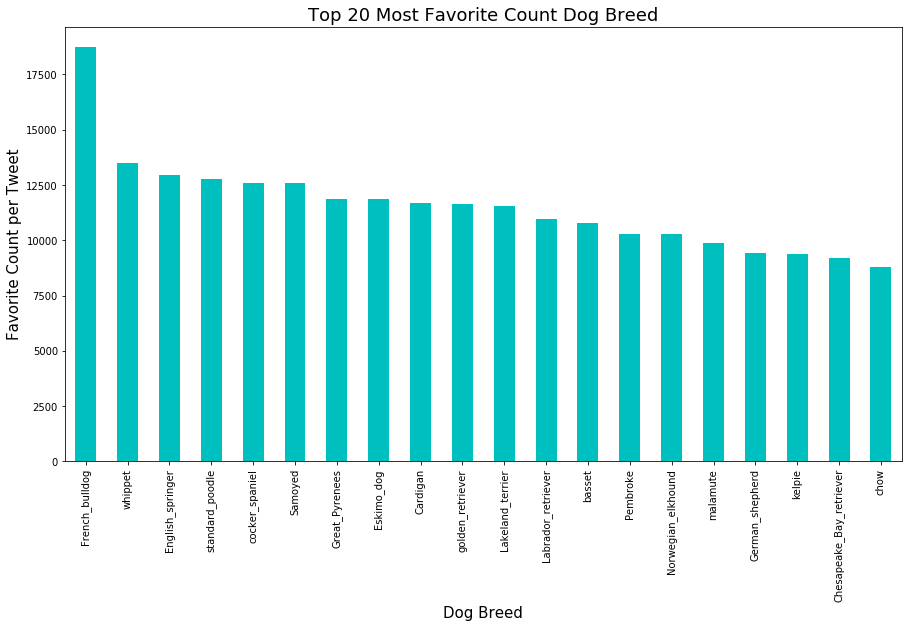

In [108]:
# plotting bar chart of top 20 most liked dog breed 
fig = plt.figure(figsize=(15,8))
fav_breed.sort_values(ascending=False).nlargest(20).plot(kind='bar', color='c')
plt.title("Top 20 Most Favorite Count Dog Breed", fontsize=18)
plt.ylabel("Favorite Count per Tweet", fontsize=15)
plt.xlabel("Dog Breed", fontsize=15);

**Observation**
- Most favorite count dog breed is French Bulldog.